In this post, we'll teach a machine learning algorithm to distinguish between pictures of dogs and pictures of cats.

## 1. Load Packages and Obtain Data

In [1]:
# loading packages
import os
import keras
from keras import utils 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

After loading the necessary packages, we load a sample data set from Kaggle that contains labeled images of cats and dogs.

In [2]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


By running the code chunk above, we've created `Dataset`s for training, validation, and testing. Then, run the following code chunk to resize the images to a fixed size of 150x150.

In [3]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

Then, run the following code chunk for rapidly reading data. The `batch_size` determines how many data points are gathered from the directory at once. 

In [4]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

We can get a piece of the data set using the `take` method; e.g. `train_ds.take(1)` will receive one batch (32 images with labels) from the training data.

To briefly explore our data set, we'll write a function to create a two-row visualization. The first row will show three random pictures of cats. The second row will show three random pictures of dogs. 

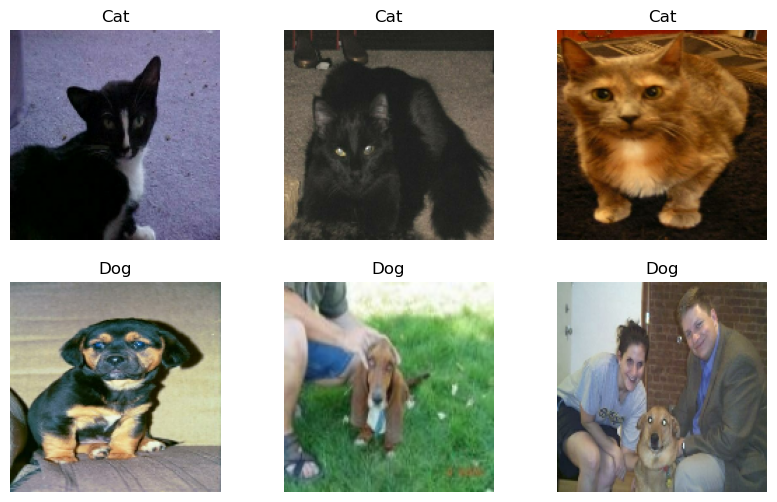

In [8]:
def visualize_cats_and_dogs(train_ds):
    plt.figure(figsize=(10, 6))

    # unbatch the dataset first
    train_ds = train_ds.unbatch()

    # shuffle the dataset to randomize the images
    train_ds = train_ds.shuffle(buffer_size=9305) # set buffer size to size of training samples

    # filter out cats and dogs
    cat_ds = train_ds.filter(lambda image, label: tf.equal(label, 0)).take(3)
    dog_ds = train_ds.filter(lambda image, label: tf.equal(label, 1)).take(3)

    # initialize the plot for cats
    for i, (image, label) in enumerate(cat_ds):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title('Cat')
        plt.axis('off')

    # initialize the plot for dogs
    for j, (image, label) in enumerate(dog_ds):
        ax = plt.subplot(2, 3, j + 4)  # indexing starts from 4 to move to the second row
        plt.imshow(image.numpy().astype('uint8'))
        plt.title('Dog')
        plt.axis('off')

    plt.show()

visualize_cats_and_dogs(train_ds)

The following line of code will create an iterator called `labels_iterator`.

In [6]:
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

Using this iterator, we'll compute the number of images in the training data with label `0` (corresponding to `"cat"`) and label `1` (corrresponding to `"dog"`). The `baseline` machine learning model is the model taht always guesses the most frequent label. 

In [7]:
# Collect all labels into a list
labels = list(labels_iterator)

# Count occurrences of each label
num_cats = labels.count(0)
num_dogs = labels.count(1)

# Calculate total number of labels
total_labels = len(labels)

# Discuss the baseline model's potential accuracy
most_frequent_label_count = max(num_cats, num_dogs)
baseline_accuracy = most_frequent_label_count / total_labels

print(f"Number of cats: {num_cats}")
print(f"Number of dogs: {num_dogs}")
print(f"Total labels: {total_labels}")
print(f"Baseline model accuracy: {baseline_accuracy:.2%}")

# This baseline accuracy will be our benchmark.

Number of cats: 4637
Number of dogs: 4668
Total labels: 9305
Baseline model accuracy: 50.17%


In this case, the baseline model would be 50.17% accurate. We will treat this as the benchmark for improvement. In order for our models to be considered good data science achievements, it should do much better than the baseline!

## 2. First Model: `keras.Sequential`

We'll first create a `keras.Sequential` model using two `Conv2D` layers, two `MaxPooling2D` layers, one `Flatten` layer, one `Dense` layer, and one `Dropout` layer.

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.5188 - loss: 46.7301 - val_accuracy: 0.5959 - val_loss: 0.6664
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: 0.6349 - loss: 0.6478 - val_accuracy: 0.6453 - val_loss: 0.6400
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.7118 - loss: 0.5712 - val_accuracy: 0.6531 - val_loss: 0.6607
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 228ms/step - accuracy: 0.7776 - loss: 0.4807 - val_accuracy: 0.6556 - val_loss: 0.6590
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.8337 - loss: 0.3855 - val_accuracy: 0.6479 - val_loss: 0.6939
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 225ms/step - accuracy: 0.8735 - loss: 0.3135 - val_accuracy: 0.6556 - val_loss: 0.7973
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.8954 - loss: 0.2622 - val_accuracy: 0.6664 - val_loss: 0.8296
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step - accuracy: 0.9218 - loss: 

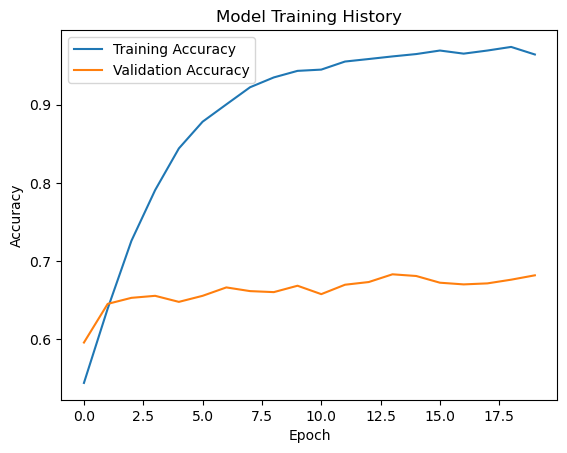

In [17]:
# define the model
model1 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# compile the model
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# train the model
history = model1.fit(train_ds, 
                     epochs =20, 
                     validation_data=validation_ds)

# plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

I tried modifying the first and second Conv2D layer to have 16 and 32 filters, respectively. In additon, I set the `Dense` layer to have 64 units. However, that resulted in the model's validation accuracy being %49.48 for the first 10 epoches. Moreover, the `loss` value ended up stablizing to 0.6933 without any improvements beyond epoch 4. So I stopped the training at epoch 12. 

Then, I modified the `Dense` layer to have 128 units. This resulted in a much better accuracy as the first epoch resulted in a validation accuracy of 59.59%. **The accuracy of model 1 stabilized between 65% to 70% during training.** This is roughly a 15% improvement in accuracy compared to the baseline. I do see some overfitting in `model1` because the training accuracy quickly outgrows the validdation accuracy. In addition, the training accuracy in the end is close to 96%, which is very high.

## 3. Second Model: Using Data Augmentation

For our second model, we'll add some *data augmentation* layers to my model. Data augmentation refers to the practice of including modified copies of the same image in the training set. For example, a picture of a cat is still a picture of a cat even if we flip it upside down or rotate it 90 degrees. We can include such transformed versions of the image in our training process in order to help our model learn so-called invariant features of our input images.

We'll randonly flip an image horizontally and vertically and plot the results!

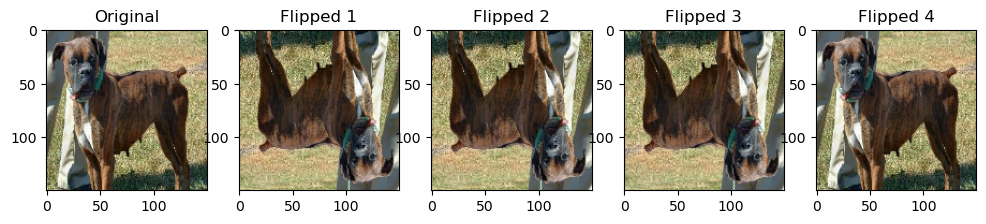

In [42]:
for images, labels in train_ds.take(1):
    image = images[0]  # Take the first image in the batch

# Create the RandomFlip layer
random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

# Display the original and flipped images
plt.figure(figsize=(12, 3))  # for better display
plt.subplot(1, 5, 1)  # for uniform spacing
plt.imshow(image.numpy().astype('uint8'))  # Convert tensor to uint8 for display
plt.title("Original")
for i in range(2, 6):  # Iterate to display multiple flipped images
    # Apply the RandomFlip layer and plot
    flipped_image = random_flip(image[None, ...], training=True)
    plt.subplot(1, 5, i)
    plt.imshow(tf.cast(flipped_image[0], tf.int32))  # Cast to int32 for proper image display
    plt.title(f"Flipped {i-1}")
plt.show()

Next, we'll try randomly rotating the image by ±10% of 360° (i.e., ±36°) and plot the results!

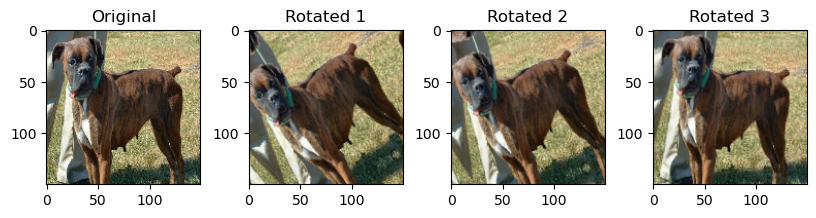

In [43]:
# create the RandomRotation layer
random_rotation = tf.keras.layers.RandomRotation(0.1)  # rotate within ±10% of 360° (i.e., ±36°)
image = tf.cast(image, tf.float32) / 255.0  # scale the image to [0, 1]

# display the original and rotated images
plt.figure(figsize=(10, 2))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original")
for i in range(2, 5):
    # apply the RandomRotation layer and plot
    rotated_image = random_rotation(image[None, ...], training=True)
    plt.subplot(1, 4, i)
    plt.imshow(rotated_image[0])  # directly use the image tensor
    plt.title(f"Rotated {i-1}")
plt.show()

We'll apply a `keras.layers.RandomFlip()` layer and a `keras.layers.RandomRotation()` layer to a `keras.models.Sequential`!

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.5478 - loss: 21.1476 - val_accuracy: 0.6101 - val_loss: 0.6665
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.5982 - loss: 0.6710 - val_accuracy: 0.6174 - val_loss: 0.6523
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.6212 - loss: 0.6508 - val_accuracy: 0.6333 - val_loss: 0.6389
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.6419 - loss: 0.6337 - val_accuracy: 0.6586 - val_loss: 0.6139
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.6474 - loss: 0.6240 - val_accuracy: 0.6496 - val_loss: 0.6162
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.6703 - loss: 0.6174 - val_accuracy: 0.6952 - val_loss: 0.5850
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/step - accuracy: 0.6975 - loss: 0.5753 - val_accuracy: 0.6999 - val_loss: 0.5680
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.7242 - loss: 

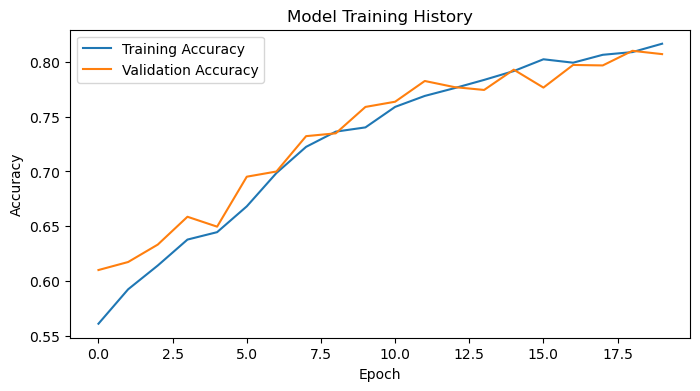

In [68]:
model2 = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history = model2.fit(train_ds, epochs=20, validation_data=validation_ds)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**The accuracy of model 2 stabilized between 75% to 81% during training.** This is roughly a 10% improvement in accuracy compared to `model1`. I don't see overfitting in `model2` because the training accuracy and validation accuracy closely follow each other in the plot above, and the final training accuracy is roughly 80%, which is reasonable. 

## 4. Third Model: Using Data Preprocessing

It can sometimes be helpul to make simple transformations to the input data so that we can improve our model's validation accuracy.  

For example, in this case, the original data has pixels with RGB values between 0 and 255, but many models will train faster with RGB values normalized between 0 and 1, or possibly between -1 and 1. These are mathematically identical situations, since we can always just scale the weights. But if we handle the scaling prior to the training process, we can spend more of our training energy handling actual signal in the data and less energy having the weights adjust to the data scale.

The following code chunk will create a preprocessing layer called `preprocessor`, which we can add to our model pipeline.

In [69]:
i = keras.Input(shape=(150, 150, 3))
# The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(i)
preprocessor = keras.Model(inputs = i, outputs = x)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.5760 - loss: 0.7294 - val_accuracy: 0.7016 - val_loss: 0.5778
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 299ms/step - accuracy: 0.6809 - loss: 0.5910 - val_accuracy: 0.7515 - val_loss: 0.5141
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 326ms/step - accuracy: 0.7254 - loss: 0.5434 - val_accuracy: 0.7756 - val_loss: 0.4755
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 53s 361ms/step - accuracy: 0.7497 - loss: 0.5120 - val_accuracy: 0.7885 - val_loss: 0.4517
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.7773 - loss: 0.4793 - val_accuracy: 0.8014 - val_loss: 0.4302
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.7807 - loss: 0.4666 - val_accuracy: 0.8057 - val_loss: 0.4278
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.7970 - loss: 0.4407 - val_accuracy: 0.8022 - val_loss: 0.4405
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.8004 - loss: 0

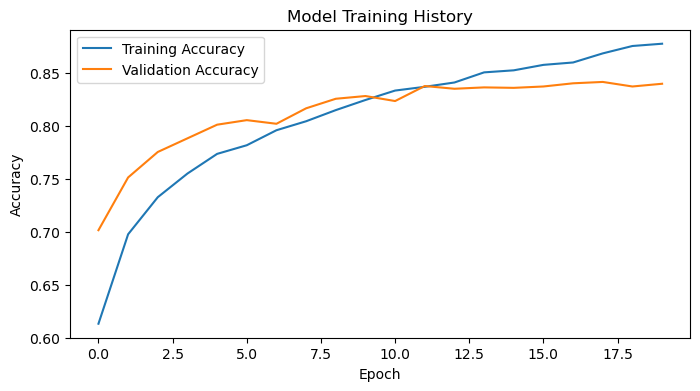

In [74]:
model3 = Sequential([
    preprocessor, 
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Train the model
history = model3.fit(train_ds, epochs=20, validation_data=validation_ds)
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**The accuracy of model 3 stabilized between 80% to 85% during training.** This is roughly a 15% improvement in accuracy compared to `model1`. I don't see overfitting in `model3`, because even though the training accuracy is higher than the valifation accuracy, the gap between the two values in the plot appear to be small. In addition, the final training accuracy is roughly 87%, which is reasonable. 

## 5. Fourth Model: Using Transfer Learning

Let's use `model3` as a base model, incorporate into a full model, and then train that model as our fourth model.

In [ ]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 319ms/step - accuracy: 0.7765 - loss: 2.4293 - val_accuracy: 0.9622 - val_loss: 0.2711
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 46s 316ms/step - accuracy: 0.9331 - loss: 0.5682 - val_accuracy: 0.9678 - val_loss: 0.2334
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.9451 - loss: 0.4454 - val_accuracy: 0.9690 - val_loss: 0.2053
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - accuracy: 0.9533 - loss: 0.3284 - val_accuracy: 0.9673 - val_loss: 0.2196
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.9557 - loss: 0.3387 - val_accuracy: 0.9656 - val_loss: 0.2315
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.9503 - loss: 0.3845 - val_accuracy: 0.9690 - val_loss: 0.1929
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.9541 - loss: 0.2786 - val_accuracy: 0.9690 - val_loss: 0.1901
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.9492 - loss: 0

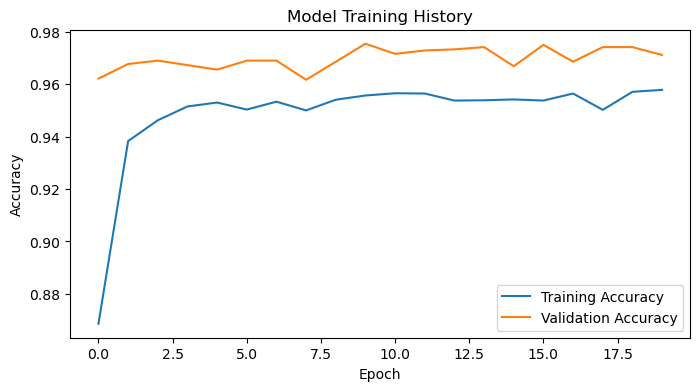

In [142]:
model4 = keras.Sequential([
    # data augmentation layers from model3
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    
    base_model,
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])

model4.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Train the model
history = model4.fit(train_ds, epochs=20, validation_data=validation_ds)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Let's check `model4.summary()` to see how many parameters we had to train in this model.

In [143]:
model4.summary()

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_88 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_91              │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_16         │ (None, 960)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 2)              │         1,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,002,120 (11.45 MB)

 Trainable params: 1,922 (7.51 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 3,846 (15.03 KB)

According to the summary table above, we trained a total of 1992 parameters, which is a lot!

**The accuracy of model 4 stabilized between 96% to 98% during training.** This is roughly a 30% improvement in accuracy compared to `model1`. There appears to be minor overfitting since there appears to be a noticeable difference between the training accuracy and the validation accuracy. 

## 6. Score on Test Data

It looks like `model4` performed the best out of the four models I've demonstrated thus far. Let's score on the test data using `model4`.

In [144]:
test_loss, test_accuracy = model4.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9685 - loss: 0.1355
Test Loss: 0.15898022055625916
Test Accuracy: 0.9673258662223816


It seems that `model4` scored a 96.73% accuracy when scored on the test data!